# Fraud Detection Example
In this Colab notebook, we'll show how you can create a virtual feature store that leverages AWS Spark (S3 + EMR) & DynamoDB to detect fraudulent transactions. 

We'll cover using: 

*   [Featureform](https://docs.featureform.com/) ➡️ Feature Store & Feature Serving
* Online Store: DynamoDB
* Offline Store: Spark (S3 + EMR) 



---


## 🎯 `Most Important Takeaways`

Specifically you'll see examples of:

*   ✅ How to connect to providers like AWS, EMR, DynamoDB, & Spark

*   ✅ Writing transformations using Spark SQL & Spark Datafram operations

*   ✅ Chaining transformations as DAGs & using curly bracket notation to reference different versions of sources & transformations

*   ✅ Creating different variants of features & training sets & zipping them up 

*   ✅ "Write once, serve twice" - Serving features for training & for production inference is as simple as providing a key & specifying whichh model & set of features you'd like to use for specific entities 

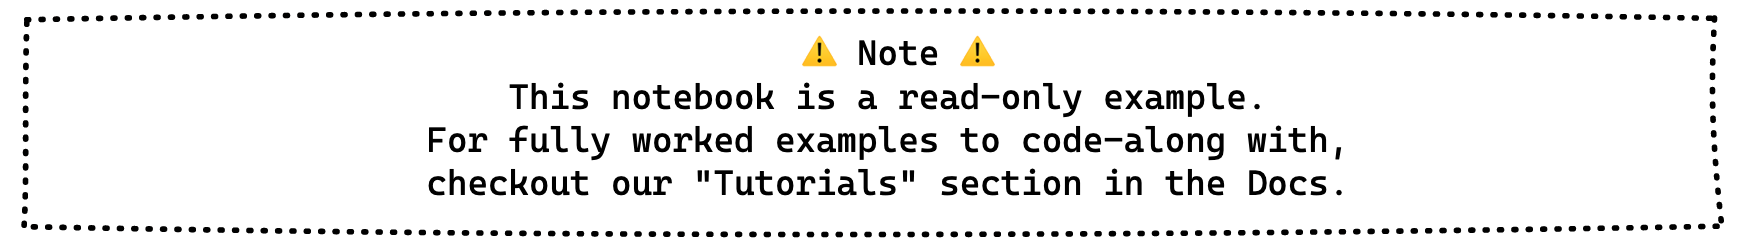

## 🚨 Prerequisites

### Reset FF Cluster

*This is only applicable to FF*

👉🏻 [Github Action Here](https://github.com/featureform/featureform/actions/workflows/reset-cluster.yml)

### Check Demo Dashboard

👉🏻 [Featureform Dashboard](http://demo.featureform.com/)

### Mount the Google Drive

The Google Drive will be used to access the credential files for Firestore & BigQuery. Make sure you have your credentials file in your drive under *credentials* folder. You will be asked to give access to mount your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verify that the credential files are accessible. Make sure you've created a shortcut to the '_credentials' folder in your GDrive.

In [ ]:
!ls ./drive/Shareddrives/Featureform/Demos_Notebooks/credentials/

aws_info.env  azure_redisent.env      bigquery.json   gcp_spark.env
azure.env     azure_redis_paired.env  firestore.json  gcs.json


In [ ]:
!pip3 -q install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path='/content/drive/Shareddrives/Featureform/Demos_Notebooks/credentials/aws_info.env')

True

In [ ]:
AWS_ACCESS_KEY_ID =  os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY')
S3_BUCKET_REGION = os.getenv('S3_BUCKET_REGION')
AWS_EMR_CLUSTER_ID = os.getenv('AWS_EMR_CLUSTER_ID')
AWS_EMR_CLUSTER_REGION = os.getenv('AWS_EMR_CLUSTER_REGION')

# 📋 Getting Setup



### Install & Import Featureform

In [ ]:
!pip -q install featureform

import featureform as ff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 86.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 81.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


### Register host

In [ ]:
client = ff.ResourceClient("demo.featureform.com")

#🏪  Using Featureform

## Register Infrastructure Provider

💬 In this case,

*   `AWS Spark (EMR + S3)` ➡️ Offline Store = provides dataset storage, transformation capabilities, and training set serving.
*   `DynamoDb `➡️ Inference Store = allows feature values to be looked up at inference time.

In [ ]:
dynamodb = ff.register_dynamodb(
    name="dynamodb",
    access_key=AWS_ACCESS_KEY_ID,
    secret_key=AWS_SECRET_KEY,
    region="us-east-1"
)

args = {
    "name": "spark",
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_KEY,
    "bucket_path": "featureform-webinar-demo",
    "bucket_region": S3_BUCKET_REGION,
    "emr_cluster_id": AWS_EMR_CLUSTER_ID,
    "emr_cluster_region": AWS_EMR_CLUSTER_REGION,
}

spark = ff.register_spark(**args)


## Register Primary Data Source (Parquet File)

In [ ]:
file = spark.register_parquet_file(
    name="transactions",
    variant="default",
    file_path="s3://ff-spark-testing/featureform/source_datasets/transaction_short/",
)

## Register our transformations (Dataframe based)

💬 There are two supported transformation types: SQL and Dataframes. Not all providers support all transformation types. 

In [ ]:
@spark.df_transformation(inputs=[("transactions", "default")])
def average_user_transaction(df):
    from pyspark.sql.functions import avg, col
    df = df.groupBy("CustomerID").agg(avg("TransactionAmount").alias("avg_transaction_amt"))
    return df.select(col("CustomerID").alias("user_id"), col("avg_transaction_amt"))

## Register Features and Labels

**Registering resources: entity**

💬 Every feature must describe an entity. An entity can be thought of as a primary key table, and every feature must have at least a single foreign key entity field.

In [ ]:
user = ff.register_entity("user")

**Registering resources: feature, label**

Once our entities are specified, we can begin to associate features and labels with them.

In [ ]:
# Register a column from our transformations as a feature
average_user_transaction.register_resources(
    entity=user,
    entity_column="user_id",
    inference_store=dynamodb,
    features=[
        {"name": "avg_transaction", "column": "avg_transaction_amt", "type": "float32"},
    ],
)

# Register label from our base file table
file.register_resources(
    entity=user,
    entity_column="CustomerID",
    labels=[
        {"name": "fraudulent", "column": "isfraud", "type": "bool"},
    ],
)

## Register training set

In [ ]:
ff.register_training_set(
    "fraud_training",
    label=("fraudulent"),
    features=["avg_transaction"],
)

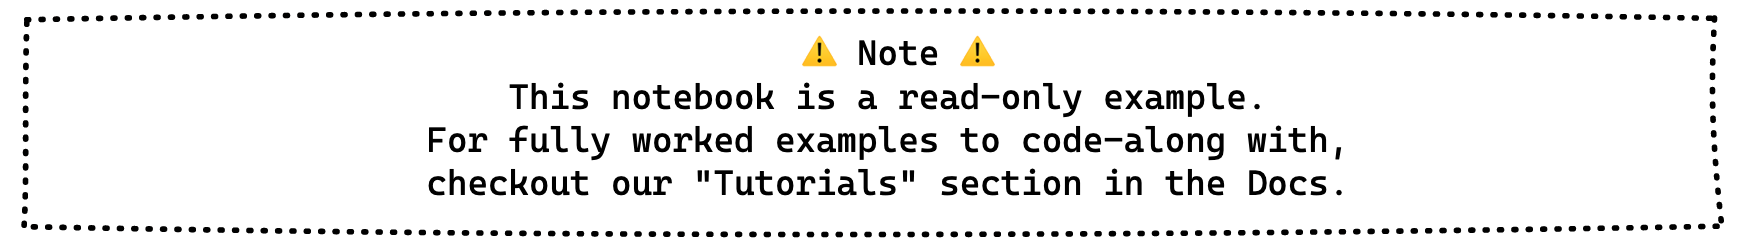

## Apply new resources to Featureform

In [ ]:
client.apply()

# 🚃 Model Training w/Served Features 👩🏻‍🍳

## Check Demo Dashboard

👉🏻 [Featureform Dashboard](http://demo.featureform.com/)

 ## Serving Features for Training

💬 When a [training set is defined](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-training-sets), it is materialized into the [offline store](https://docs.featureform.com/getting-started/registering-infrastructure-providers#offline-store) associated with the definition. 

**Fetch the Training Set via Client**

In [ ]:
client = ff.ServingClient("demo.featureform.com")
dataset = client.training_set("fraud_training", "default")
training_dataset = dataset.repeat(1).shuffle(1000).batch(12)

**Examine Values**

In [ ]:
for row in dataset:
  print(row.features(),row.label())
  break

**Train Model with Fetched Features**

💬 Once we have our training set and features registered, we can train our model.

In [ ]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log')
for batch in training_dataset:
  classifier.partial_fit(batch.features(), batch.label(), classes=['true', 'false'])

# Get one batch of training data as sample test data
# Make a test prediction
classifier.predict(batch.features())



## Serve features for inference

💬 We can serve features in production once we deploy our trained model as well.

In [ ]:
feature = client.features(["avg_transaction"], {"user":"C4650842"})
print(feature)

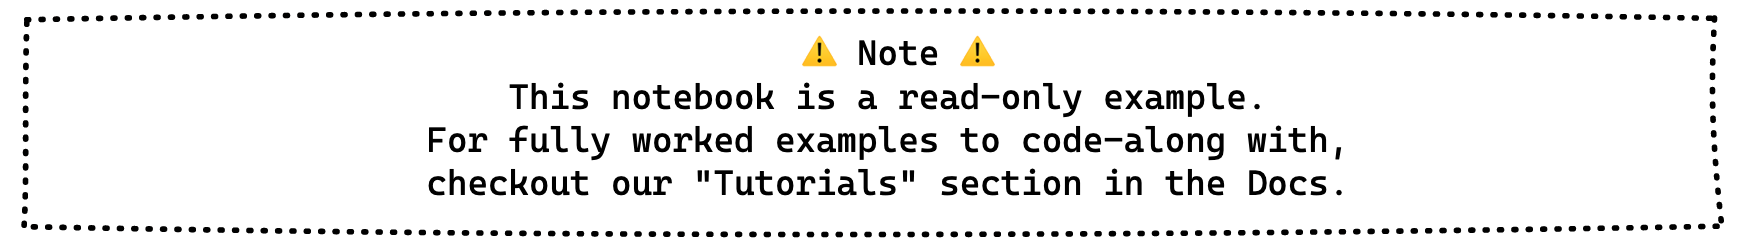